# Group D Simple Classification

T. Lindner first notebook...

Fast streaming of data is extremely important for training ML algorithms. As such, ML libraries including `pytorch` provide useful APIs to load data during training. In this notebook, we go over an example of how to implement `pytorch` APIs for streaming the workshop data. 

We assume you know how to open the workshop `.npz` data files. If you do not know what that is, or have not yet tried [HKML Data Access & Visualization](https://github.com/WatChMaL/ExampleNotebooks/blob/master/HKML%20Data%20Access%20%26%20Visualization.ipynb) notebook, you should start from there.



There are 2 base `pytorch` modules to be implemented:
* `Dataset` ... a blob data instance, defines how data should be read from file, etc.
* `DataLoader` ... for streaming data segments from `Dataset`

In [1]:
from __future__ import print_function
import numpy as np
import os, time
import matplotlib.pyplot as plt
%matplotlib inline
from torch.utils.data import Dataset, DataLoader

# Data directories: let's use e- and mu-
DATA_DIRS = ['/data/hkml_data/IWCDgrid/varyE/e-','/data/hkml_data/IWCDgrid/varyE/mu-','/data/hkml_data/IWCDgrid/varyE/gamma']



## Dataset
`Dataset` module needs implementation of two attributes: `__len__` (length of our dataset) and `__getitem__` (called to fetch an item in the ordered dataset). Below, we define `NPZDataset` which reads data from files whenever requested.

Use the HDF5 format

In [12]:
import h5py
# Open a file
f = h5py.File('/data/hkml_data/IWCDgrid/varyE/e-/IWCDgrid_varyE_e-_R0cm_20-2000MeV_100k.h5', mode='r')
# List keys
for key in f.keys():
    print('%s ... Shape %s' % (key, str(f[key].shape)))

directions ... Shape (100000, 1, 3)
energies ... Shape (100000, 1)
event_data ... Shape (100000, 88, 168, 2)
labels ... Shape (100000,)
pids ... Shape (100000, 1)
positions ... Shape (100000, 1, 3)


## DataLoader
Given a `Dataset` instance, `DataLoader` provides handy features for streaming data including randomization of samples, multi-threaded data read/process (e.g. `transform` function in `Dataset`), etc.. 

The `DataLoader` is for ML training where we typically access data by a chunk, called _batch_ (or sometimes _mini batch_). The number of samples (e.g. events) in each batch is called _batch size_ (or _mini batch size_). When preparing a batch, `DataLoader` combines (or collates) N events where N is the batch size. You need to provide a function to perform this collation.

In [13]:
class H5Dataset(Dataset):

    def __init__(self, data_dirs, transform=None, flavour=None, limit_num_files=0, start_fraction=0., use_fraction=1.0):
        """                               
        
        Args: data_dirs ... a list of data directories to find files (up to 10 files read from each dir)                                                
              transform ... a function applied to pre-process data                                                                                      
              flavour ..... a string that is required to be present in the filename                                                                     
              limit_num_files ... an integer limiting number of files to be taken per data directory                                                    
              start_fraction ... a floating point fraction (0.0=>1.0) to specify which entry to start reading (per file)                                
              use_fraction ..... a floating point fraction (0.0=>1.0) to specify how much fraction of a file to be read out (per file)                  
        """
        self._transform = transform
        self._files = []

        # Check input fractions makes sense                                                                                                             
        assert start_fraction >= 0. and start_fraction < 1.
        assert use_fraction > 0. and use_fraction <= 1.
        assert (start_fraction + use_fraction) <= 1.

        # Load files (up to 10) from each directory in data_dirs list                                                                                   
        for d in data_dirs:
            file_list = [ os.path.join(d,f) for f in os.listdir(d) if flavour is None or flavour in f ]
            if limit_num_files: file_list = file_list[0:limit_num_files]
            self._files += file_list

        self._file_handles = [None] * len(self._files)
        self._event_to_file_index  = []
        self._event_to_entry_index = []
        import h5py
        for file_index, file_name in enumerate(self._files):
            f = h5py.File(file_name,mode='r')
            data_size = f['event_data'].shape[0]
            start_entry = int(start_fraction * data_size)
            num_entries = int(use_fraction * data_size)
            self._event_to_file_index += [file_index] * num_entries
            self._event_to_entry_index += range(start_entry, start_entry+num_entries)
            f.close()

    def __len__(self):
        return len(self._event_to_file_index)

    def __getitem__(self,idx):
        file_index = self._event_to_file_index[idx]
        entry_index = self._event_to_entry_index[idx]
        if self._file_handles[file_index] is None:
            import h5py
            self._file_handles[file_index] = h5py.File(self._files[file_index],mode='r')
        fh = self._file_handles[file_index]
        return fh['event_data'][entry_index],fh['labels'][entry_index],idx

Now try plotting the data loaded from HDF5 file

300000 total events are loaded!
Entry 299999 ... label: 0.0 ... data shape: (88, 168, 2)


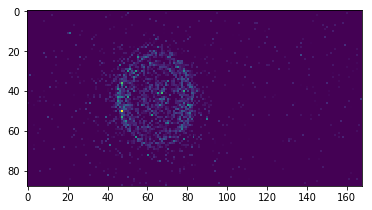

In [25]:
ENTRY = 299999
ds = H5Dataset(DATA_DIRS,flavour='100k.h5')
print(len(ds),'total events are loaded!')
# Access an index
data,label,idx = ds[ENTRY]
# Data shape
print('Entry',ENTRY,'... label:',label,'... data shape:',data.shape)
# Visualize
plt.imshow(data[:,:,0])
plt.show()

Access "5th event" and visualize

Now we can define the dataloader.

In [7]:
loader = DataLoader(ds,
                    batch_size=5, # set the batch size = 5
                    shuffle=True,  # enable randomization of samples in a batch
                    num_workers=1, # number of workers to parallelize data streaming
                    collate_fn=HKCollate # collation method
                   )

Here's how you can loop over 10 batch samples

In [8]:
def loop(loader,loop_limit=3):

    # Let's measure time that takes in each loop
    trecord = np.zeros([loop_limit],dtype=np.float32)
    t = time.time()
    for iteration, batch in enumerate(loader):

        data,label,index = batch

        # Print out some content info
        print('Iteration',iteration,'... time:',time.time()-t,'[s]')
        print('    Labels:',label)
        print('    Index :',index,'\n')
        trecord[iteration] = time.time() - t
        t = time.time()

        # break when reaching the loop limit
        if (iteration+1) == loop_limit:
            break
    return trecord

Let's try running data loader for 5 events

In [9]:
time_record = loop(loader,5)
print('Overall average iteration time:',time_record.mean(),'[s]')
print('First event     iteration time:',time_record[0],    '[s]')
print('After first event average time:',time_record[1:].mean(),'[s]')

Iteration 0 ... time: 4.7319290638 [s]
    Labels: [1, 1, 1, 0, 2]
    Index : [291915, 568804, 543959, 2254332, 1844292] 

Iteration 1 ... time: 4.53579282761 [s]
    Labels: [1, 1, 0, 0, 2]
    Index : [487496, 845954, 3033952, 2688582, 1627776] 

Iteration 2 ... time: 4.52432894707 [s]
    Labels: [2, 0, 0, 0, 0]
    Index : [1804856, 2779690, 2769579, 3166423, 2474419] 

Iteration 3 ... time: 4.5158200264 [s]
    Labels: [0, 2, 2, 1, 1]
    Index : [2582171, 1370242, 1829646, 822816, 38969] 

Iteration 4 ... time: 4.4926879406 [s]
    Labels: [2, 0, 2, 2, 0]
    Index : [1806705, 2665824, 1269820, 1501793, 2848264] 

Overall average iteration time: 4.5616446 [s]
First event     iteration time: 4.7342234 [s]
After first event average time: 4.5184994 [s]


... that was SO SLOW! I hope you have not yet thrown your laptop yet ;) This slow speed is due to the fact that, for each event, we are performing file open & close. This is very inefficient.

## _Faster_ data streaming

There are three possible solutions to an issue of slow data streaming. 
0. read ALL data in the RAM upfront (e.g. creation of `Dataset`)
1. increase number of _workers_ to read data (i.e. parallelization)
2. combination of 0 and 1: employ parallelization while utilizing some data cache in RAM

The first and last methods are bounded by the size of RAM memory availability. Here, we try the option 1. This can be done by specifying _num workers_ argument value at the construction of `DataLoader`.

In [17]:
loader = DataLoader(ds,
                    batch_size=5, # set the batch size = 5
                    shuffle=True,  # enable randomization of samples in a batch
                    num_workers=15, # number of workers to parallelize data streaming
                    collate_fn=HKCollate # collation method
                   )
time_record = loop(loader,10)
print('Overall average iteration time:',time_record.mean(),'[s]')
print('First event     iteration time:',time_record[0],    '[s]')
print('After first event average time:',time_record[1:].mean(),'[s]')

Iteration 0 ... time: 21.5281150341 [s]
    Labels: [2, 0, 1, 1, 0]
    Index : [1424935, 2434870, 215074, 408486, 2634047] 

Iteration 1 ... time: 3.50475311279e-05 [s]
    Labels: [0, 2, 0, 1, 2]
    Index : [2841985, 2121443, 2798182, 1097064, 1359555] 

Iteration 2 ... time: 0.598119020462 [s]
    Labels: [1, 0, 1, 0, 2]
    Index : [185969, 2867488, 709325, 2212701, 1470174] 

Iteration 3 ... time: 3.09944152832e-05 [s]
    Labels: [2, 1, 1, 2, 0]
    Index : [1423893, 484411, 945071, 1762159, 3281448] 

Iteration 4 ... time: 3.38554382324e-05 [s]
    Labels: [2, 2, 1, 0, 0]
    Index : [1605598, 1789078, 196569, 2266440, 3163785] 

Iteration 5 ... time: 2.40802764893e-05 [s]
    Labels: [0, 1, 1, 1, 0]
    Index : [2787802, 757245, 360046, 358952, 3228577] 

Iteration 6 ... time: 2.8133392334e-05 [s]
    Labels: [1, 0, 1, 1, 2]
    Index : [713669, 2262305, 24289, 527451, 1905482] 

Iteration 7 ... time: 2.78949737549e-05 [s]
    Labels: [0, 1, 2, 1, 2]
    Index : [3166111, 1057

The first event takes some time. This is because all workers are initiated and nothing is read yet. However, while 5 workers are reading 5 events to form the first batch, 10 other workers are reading data in parallel and store in a buffer. From the second event and onwards, data in a buffer is loaded (i.e. faster data streaming). At some point, parllel workers and data query will balance out and the speed reaches an equilibrium. You have a good solution when the data streaming speed at the equilibrium is much smaller than the time it takes to consume data, which is an algorithm training step to consume 1 batch of data.

## Fasteeeerrr way
Can we do better? We certainly can! and it is good to care: the data streaming speed is one of a typical bottleneck in developing ML applications. The best performance can be achieved with the option _2. employ parallelization while utilizing some data cache in RAM_. You can implement this by yourself, or partially borrow features from awesome software libraries. One of those is [`HDF5`](https://www.hdfgroup.org/), which has been accepted as a solution for challenges at a varying scale, from a small project on a laptop to a large-scale distributed computing at High Performance Computing clusters. 

The workshop data is available in `HDF5` format (with `.h5` file extension). Accessing HDF5 file can be easily done using `h5py` module.

In [18]:
import h5py
# Open a file
f = h5py.File('/data/hkml_data/IWCDgrid/varyE/e-/IWCDgrid_varyE_e-_R0cm_20-2000MeV_100k.h5', mode='r')
# List keys
for key in f.keys():
    print('%s ... Shape %s' % (key, str(f[key].shape)))

directions ... Shape (100000, 1, 3)
energies ... Shape (100000, 1)
event_data ... Shape (100000, 88, 168, 2)
labels ... Shape (100000,)
pids ... Shape (100000, 1)
positions ... Shape (100000, 1, 3)


Let's define `Dataset` that accesses `h5` files.

In [19]:
class H5Dataset(Dataset):

    def __init__(self, data_dirs, transform=None, flavour=None, limit_num_files=0, start_fraction=0., use_fraction=1.0):
        """                               
        
        Args: data_dirs ... a list of data directories to find files (up to 10 files read from each dir)                                                
              transform ... a function applied to pre-process data                                                                                      
              flavour ..... a string that is required to be present in the filename                                                                     
              limit_num_files ... an integer limiting number of files to be taken per data directory                                                    
              start_fraction ... a floating point fraction (0.0=>1.0) to specify which entry to start reading (per file)                                
              use_fraction ..... a floating point fraction (0.0=>1.0) to specify how much fraction of a file to be read out (per file)                  
        """
        self._transform = transform
        self._files = []

        # Check input fractions makes sense                                                                                                             
        assert start_fraction >= 0. and start_fraction < 1.
        assert use_fraction > 0. and use_fraction <= 1.
        assert (start_fraction + use_fraction) <= 1.

        # Load files (up to 10) from each directory in data_dirs list                                                                                   
        for d in data_dirs:
            file_list = [ os.path.join(d,f) for f in os.listdir(d) if flavour is None or flavour in f ]
            if limit_num_files: file_list = file_list[0:limit_num_files]
            self._files += file_list

        self._file_handles = [None] * len(self._files)
        self._event_to_file_index  = []
        self._event_to_entry_index = []
        import h5py
        for file_index, file_name in enumerate(self._files):
            f = h5py.File(file_name,mode='r')
            data_size = f['event_data'].shape[0]
            start_entry = int(start_fraction * data_size)
            num_entries = int(use_fraction * data_size)
            self._event_to_file_index += [file_index] * num_entries
            self._event_to_entry_index += range(start_entry, start_entry+num_entries)
            f.close()

    def __len__(self):
        return len(self._event_to_file_index)

    def __getitem__(self,idx):
        file_index = self._event_to_file_index[idx]
        entry_index = self._event_to_entry_index[idx]
        if self._file_handles[file_index] is None:
            import h5py
            self._file_handles[file_index] = h5py.File(self._files[file_index],mode='r')
        fh = self._file_handles[file_index]
        return fh['event_data'][entry_index],fh['labels'][entry_index],idx

Let's create `Dataset` instance and try accessing an entry, just like how we did before for `.npz` files.

300000 total events are loaded!
Entry 5 ... label: 1.0 ... data shape: (88, 168, 2)


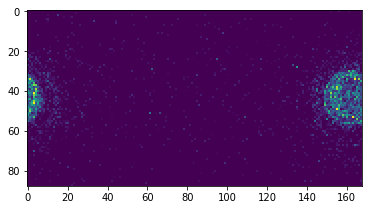

In [13]:
ds = H5Dataset(DATA_DIRS,flavour='100k.h5')
print(len(ds),'total events are loaded!')
# Access an index
data,label,idx = ds[ENTRY]
# Data shape
print('Entry',ENTRY,'... label:',label,'... data shape:',data.shape)
# Visualize
plt.imshow(data[:,:,0])
plt.show()

Let's test how much faster it can be:

In [14]:
loader = DataLoader(ds,
                    batch_size=5,  # set the batch size = 50
                    shuffle=True,  # enable randomization of samples in a batch
                    num_workers=1, # number of workers to parallelize data streaming
                    collate_fn=HKCollate # collation method
                   )
time_record = loop(loader,10)
print('Overall average iteration time:',time_record.mean(),'[s]')
print('First event     iteration time:',time_record[0],    '[s]')
print('After first event average time:',time_record[1:].mean(),'[s]')

Iteration 0 ... time: 0.0576930046082 [s]
    Labels: [0.0, 2.0, 2.0, 2.0, 0.0]
    Index : [289258, 152784, 140551, 138013, 276611] 

Iteration 1 ... time: 0.000949859619141 [s]
    Labels: [1.0, 0.0, 2.0, 1.0, 2.0]
    Index : [92912, 291664, 145655, 45847, 175040] 

Iteration 2 ... time: 0.0260651111603 [s]
    Labels: [2.0, 2.0, 1.0, 1.0, 1.0]
    Index : [141712, 179878, 82490, 89560, 50964] 

Iteration 3 ... time: 0.000847101211548 [s]
    Labels: [0.0, 1.0, 0.0, 0.0, 0.0]
    Index : [205889, 74509, 216278, 242041, 248335] 

Iteration 4 ... time: 0.0270299911499 [s]
    Labels: [1.0, 0.0, 1.0, 0.0, 2.0]
    Index : [99717, 273419, 250, 205020, 191003] 

Iteration 5 ... time: 0.000716924667358 [s]
    Labels: [1.0, 0.0, 0.0, 1.0, 0.0]
    Index : [94485, 245394, 297184, 53755, 295885] 

Iteration 6 ... time: 0.0212218761444 [s]
    Labels: [2.0, 1.0, 1.0, 2.0, 1.0]
    Index : [163758, 94070, 72157, 194761, 84368] 

Iteration 7 ... time: 0.000784873962402 [s]
    Labels: [2.0, 2.

... which is indeed orders of magnitude faster!

### Why only 1 worker?
Well, my fault: it is not possible (or practically hard) to support multiple reader processes for HDF5 files in python 2.7. It is my fault for not using Python3 in a workshop like this in 2019 :( See single-writer-multiple-reader (SWMR) discussion here: https://github.com/pytorch/pytorch/issues/3415#issuecomment-341079534

### Closing remark

This point of this exercise is to see how much difference in data streaming speed you can make. When combined with GPU, moving data from CPU RAM to GPU is another important point to care (i.e. a good practice can get you factors or even an order of magnitude speed up). Training a ML algorithm involves a large dataset that cannot all fit in RAM, and there will be many, many random order data access. The speed of streaming data directly affects time it takes to run your ML algorithms. Finally, though we used `HDF5` in this exercise, `ROOT` is not your enemy when it comes to data streaming. It has descent speed as well as flexibility in both data serialization and compression. Many ML applications use `ROOT` data format in HEP.

If you have questions/suggestions/concerns, [contact me](mailto:kterao@slac.stanford.edu)!